In [15]:
import numpy as np
import cv2
import misc
# from RL_networks import Stand_alone_net
# import pickle
# import random

import tensorflow as tf
import tensorflow.keras as keras

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# np.__version__

import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import SYCLOP_env as syc

from torch.utils.data import Dataset, DataLoader

In [11]:
from mnist import MNIST

mnist = MNIST('/home/labs/ahissarlab/bnassa/datasets/mnist/')
images, labels = mnist.load_training()

In [162]:
#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    
    return upsmp

In [ ]:
def generate_eclamp_traj(timesteps = 5 ,res = 6, random_dir = True):
    fixed_dir = [0, np.pi/2, np.pi, -np.pi/2, np.pi]
    traj_list = []

    #Set the sensor and the agent
    img=misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28]))
    scene = syc.Scene(image_matrix=img)
    sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
    agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
    sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))


    for img_num,img in enumerate(images):
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
    #     print("img: ", img_num)

        #Set the scene
        scene = syc.Scene(image_matrix=img)

        #Set the agent
        agent.reset()
        starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2],dtype=int)
#         starting_point += np.random.randint(-5,5,2)

        q1 = [0,0]
        steps  = []
        steps.append(starting_point*1)
        for j in range(timesteps):
            if random_dir:
                ssteps = sensor.eclamp_max_substeps
                while ssteps == sensor.eclamp_max_substeps:
                    agent.set_manual_q(steps[-1])
                    phi = 2 * np.pi * random.random()
                    q1, ssteps = sensor.eclamp_step(scene, agent, phi)
            else:
                agent.set_manual_q(steps[-1])
                phi = fixed_dir[j]
                q1, ssteps = sensor.eclamp_step(scene, agent, phi)

            steps.append( q1 )

        q_sequence = np.array(steps).astype(int)
        traj_list.append(q_sequence)
        
    return traj_list

In [ ]:
def generate_fixed_traj(q_sequence):
    
    traj_list = []
    for img_num,img in enumerate(images):
        traj_list.append(q_sequence)
    
    return traj_list

In [ ]:
def generate_fixed_traj_rand_start_point():
     
    traj_diff = [[2,0], [0,2], [-2,0], [0,-3]]
    traj_list = []

    for img_num,img in enumerate(images):
        starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
        starting_point += np.random.randint(-5,5,2)
        
        steps = []
        steps.append(starting_point*1)
        for j in range(4):
            starting_point += traj_diff[j]
            steps.append(starting_point*1)
                
        
        traj_list.append(steps)
    
    return traj_list

In [33]:
def rnn_model(n_timesteps = 5):
    inputA = keras.layers.Input(shape=(n_timesteps,28,28,1))
    inputB = keras.layers.Input(shape=(n_timesteps,2))

    # define CNN model
    x1=keras.layers.TimeDistributed(keras.layers.Conv2D(16,(3,3),activation='relu'))(inputA)
    x1=keras.layers.TimeDistributed(keras.layers.BatchNormalization())(x1)
    x1=keras.layers.TimeDistributed(keras.layers.MaxPooling2D(pool_size=(2, 2)))(x1)

    x1=keras.layers.TimeDistributed(keras.layers.Conv2D(32,(3,3),activation='relu'))(x1)
    x1=keras.layers.TimeDistributed(keras.layers.BatchNormalization())(x1)
    x1=keras.layers.TimeDistributed(keras.layers.MaxPooling2D(pool_size=(2, 2)))(x1)

    x1=keras.layers.TimeDistributed(keras.layers.Conv2D(16,(3,3),activation='relu'))(x1)
    print(x1.shape)

    x1=keras.layers.TimeDistributed(keras.layers.MaxPooling2D(pool_size=(2, 2)))(x1)
    print(x1.shape)

    x1=keras.layers.TimeDistributed(keras.layers.Flatten())(x1)
    print(x1.shape)

    x = keras.layers.Concatenate()([x1,inputB])
    print(x.shape)
    # define LSTM model
    x = keras.layers.GRU(100,input_shape=(n_timesteps, None),return_sequences=False)(x)
    x = keras.layers.Dense(10,activation="softmax")(x)
    model = keras.models.Model(inputs=[inputA,inputB],outputs=x)
    opt=tf.keras.optimizers.Adam(lr=1e-3)
 
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

In [13]:
def create_dataset(images, labels, res, sample = 5, mixed_state = True, add_traject = True,
                   trajectory_list=None,return_datasets=False):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.
    return_datasets: rerutns datasets rather than dataloaders
    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    q_seq = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img_num,img in enumerate(images):
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        if trajectory_list is None:
            starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
            starting_point += np.random.randint(-5,5,2)#eldad
            steps  = []
            for j in range(5):
                steps.append(starting_point*1)
                starting_point += np.random.randint(-5,5,2) 

            if mixed_state:
                q_sequence = np.array(steps).astype(int)
            else:
                if count == 0:
                    q_sequence = np.array(steps).astype(int)
        else:
            q_sequence = np.array(trajectory_list[img_num]).astype(int)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[0]) 
            plt.title(labels[count])
            i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        q_seq.append(q_sequence)
        count += 1
        

    
    if add_traject: #If we add the trjectories the train list will become a list of lists, the images and the 
        #corrosponding trajectories, we will change the dataset structure as well. Note the the labels stay the same.
        ts_train = [ts_images[:55000], q_seq[:55000]] 
#         ts_train = [dvs_images[:55000], q_seq[:55000]] 
        train_labels = labels[:55000]
        ts_val = [ts_images[55000:], q_seq[55000:]]
#         ts_val = [dvs_images[55000:], q_seq[55000:]]
        val_labels = labels[55000:]

    else:
        ts_train = ts_images[:55000]
        train_labels = labels[:55000]
        ts_val = ts_images[55000:]
        val_labels = labels[55000:]

    dvs_train = dvs_images[:55000]
    dvs_val = dvs_images[55000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, add_traject = False, transform = None):

            self.data = data
            self.labels = labels

            self.add_traject = add_traject
            self.transform = transform
        def __len__(self):
            if self.add_traject: 
                return len(self.data[0]) 
            else: return len(self.data[0])


        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            if self.add_traject:
                img_data = self.data[0][idx] 
                traject_data = self.data[1][idx]
                label = self.labels[idx]
                return img_data, traject_data, label
            else:
                data = self.data[idx]



            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels
        
    train_dataset = mnist_dataset(ts_train, train_labels,add_traject = True)
    test_dataset = mnist_dataset(ts_val, val_labels,add_traject = True)
    batch = 64
#     train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
#     test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    if return_datasets:
        return train_dataset, test_dataset
    else:
        return train_dataloader, test_dataloader, ts_train, train_labels


In [17]:
def split_dataset_xy(dataset, timesteps = 5):
    dataset_x1 = [uu[0] for uu in dataset]
    dataset_x2 = [uu[1] for uu in dataset]
    dataset_y = [uu[-1] for uu in dataset]
    return (np.array(dataset_x1)[...,np.newaxis],np.array(dataset_x2)[:,:timesteps,:]),np.array(dataset_y)

(?, 5, 3, 3, 16)
(?, 5, 144)
(?, 5, 144)
Fit model on training data
Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 44s 798us/sample - loss: 1.2474 - sparse_categorical_accuracy: 0.5843 - val_loss: 0.9249 - val_sparse_categorical_accuracy: 0.6988


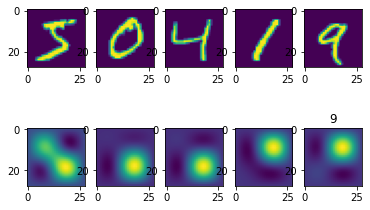

In [149]:
# RES_LIST = [4, 6, 8, 10, 12]
RES_LIST = [6]
TIMESTEPS = 5

# traj_l = []
q_seq = [[36,36],[38,36],[38,38],[36,38],[36,35]]
acc = np.zeros(len(RES_LIST))
val_acc = np.zeros(len(RES_LIST))
for indx,res in enumerate(RES_LIST):

#     traj_l = generate_fixed_traj(q_seq)
#     traj_l = generate_eclamp_traj(TIMESTEPS, res)
#     traj_l = generate_eclamp_traj(TIMESTEPS, res, random_dir = False)
#     traj_l = generate_fixed_traj_rand_start_point()

    train_dataset, test_dataset = create_dataset(images, labels,res = res,return_datasets=True, trajectory_list = traj_l)
#     train_dataset, test_dataset = create_dataset(images, labels,res = res,return_datasets=True)
  
    train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset, TIMESTEPS)
    test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset, TIMESTEPS)
    train_dataset_x = train_dataset_x[0]
    test_dataset_x = test_dataset_x[0]

    rnn = rnn_model(TIMESTEPS)
    print("Fit model on training data")
    history = rnn.fit(
        train_dataset_x,
        train_dataset_y,
        batch_size=64,
        epochs=1,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        validation_data=(test_dataset_x, test_dataset_y)) #(validation_images, validation_labels)


    acc[indx] = history.history['sparse_categorical_accuracy'][0]
    val_acc[indx] = history.history['val_sparse_categorical_accuracy'][0]


### Analysis and testing

In [ ]:
agent.set_manual_q(starting_point)
view0 = sensor.get_view(scene,agent)
# view0.shape

agent.set_manual_q(starting_point + [10,10])
view1 = sensor.get_view(scene,agent)

dvs_view = sensor.dvs_fun(view1,view0)

plt.figure()
plt.imshow(view0)
plt.figure()
plt.imshow(view1)
plt.figure()
plt.imshow(dvs_view)
# view0

In [ ]:
# val_acc_eclamp_fixed = val_acc
# acc_eclamp_fixed = acc
# train_dataset_x_eclamp_fixed = train_dataset_x

In [ ]:
plt.figure()
plt.plot(RES_LIST, val_acc_random, 'ob')
plt.plot(RES_LIST, val_acc_eclamp, 'or')
plt.plot(RES_LIST, val_acc_eclamp_fixed, 'ok')
plt.plot(RES_LIST, val_acc_fixed, 'og')
plt.legend(['random','random eclamp', 'fixed eclamp', 'fixed traj'])
plt.xlabel('res')
plt.ylabel('val acc')
plt.savefig('eclamp_accuracy.png')

(31.6, 40.4, 19.85, 45.15)

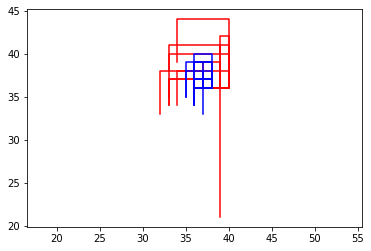

In [19]:
# im=misc.build_mnist_padded(1./256*np.reshape(images[3],[1,28,28]))
plt.figure()
# plt.imshow(im)

traj_1 = train_dataset_x[1][train_dataset_y==1,:,:]
traj_0 = train_dataset_x[1][train_dataset_y==0,:,:]
for seq in traj_1[:10]:
    plt.plot(seq[:,0],seq[:,1], 'r')
for seq in traj_0[:10]:
    plt.plot(seq[:,0],seq[:,1], 'b')

plt.axis('equal')

In [ ]:
plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==0,4,1], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==1,4,1], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==2,4,1], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==3,4,1], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==4,4,1], bins=20)

plt.figure()
plt.hist(train_dataset_x[1][train_dataset_y==5,4,1], bins=20)

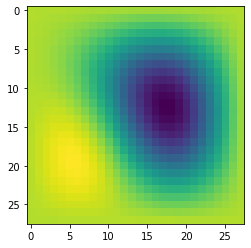

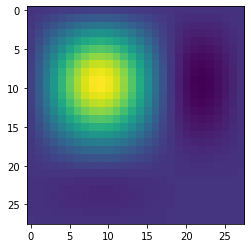

In [150]:
img_ind = 8
# print(train_dataset_x[1][img_ind,:,:]-22)

plt.figure()
plt.imshow(train_dataset_x[img_ind,0,:,:,0])
plt.figure()
plt.imshow(train_dataset_x[img_ind,1,:,:,0])
# plt.figure()
# plt.imshow(train_dataset_x[0][img_ind,2,:,:,0])
# plt.figure()
# plt.imshow(train_dataset_x[0][img_ind,3,:,:,0])
# plt.figure()
# plt.imshow(train_dataset_x[0][img_ind,4,:,:,0])

False


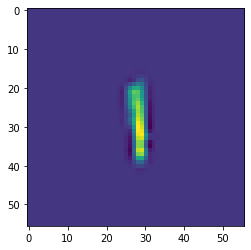

In [172]:
img = misc.build_mnist_padded(1./256*np.reshape(images[8],[1,28,28]))

q = [36,36]
view =  img[128 - q[1] - 56: 128 - q[1], q[0]: q[0] + 56]
view_bad_res = bad_res101(view,(28,28))

plt.figure()
plt.imshow(view_bad_res)
print((view_bad_res==0.0).all())

In [153]:
indxs_empty = []
sum_empty = 0
for tx_ind, tx in enumerate(train_dataset_x):
    for view in tx[:1]:
#     for view in tx:
#         plt.figure()
#         plt.imshow(view)
         sum_empty += (view==0).all()
         if (view==0).all():
             indxs_empty.append(tx_ind)

print(sum_empty) 

0


## sensor.hp.winx

In [155]:
test_predictions = rnn.predict(test_dataset_x)

In [156]:
predicted_digit = []
for sample_pred in test_predictions:
    pred = np.where(sample_pred == np.max(sample_pred))
    predicted_digit.append(pred[0][0])

predicted_digit = np.array(predicted_digit)

In [157]:
digit = 1
np.sum(predicted_digit[test_dataset_y==digit]==digit)/np.sum(test_dataset_y==digit)

0.9584905660377359

In [ ]:
train_dataset_x[0][img_ind,0,:,:,0]